# BioMON: Few-shot Meta-learning Architectures with Classification Base Learners for Biomedical Datasets.
Manos Chatzakis (emmanouil.chatzakis@epfl.ch), Lluka Stojollari (lluka.stojollari@epfl.ch)

This notebook processes the results of the training and evaluation of BioMON along with other algorithms and creates the figures of the report. 

## Get Started!

Make sure the results are generated and that the required packages are installed.

In [3]:
# To install dependencies:
# %pip3 install -r requirements.txt

# To generate the results:
# %./run_all.sh # Make sure to run this with a GPU, else, it might take a while

## Imports and utilities

Make sure to install the required packages to import the following libraries.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import csv

RESULTS_DIR = "./results/final"

## BioMON Training and Variatons comparisons

In this section, we explore the data from the training of various BioMON versions, and plot our results. Moreover, we compare the performance of different BioMON heads.

### Training summaries of the classifiers

Here, we plot the training summaries of all the classifiers used in the evaluation.

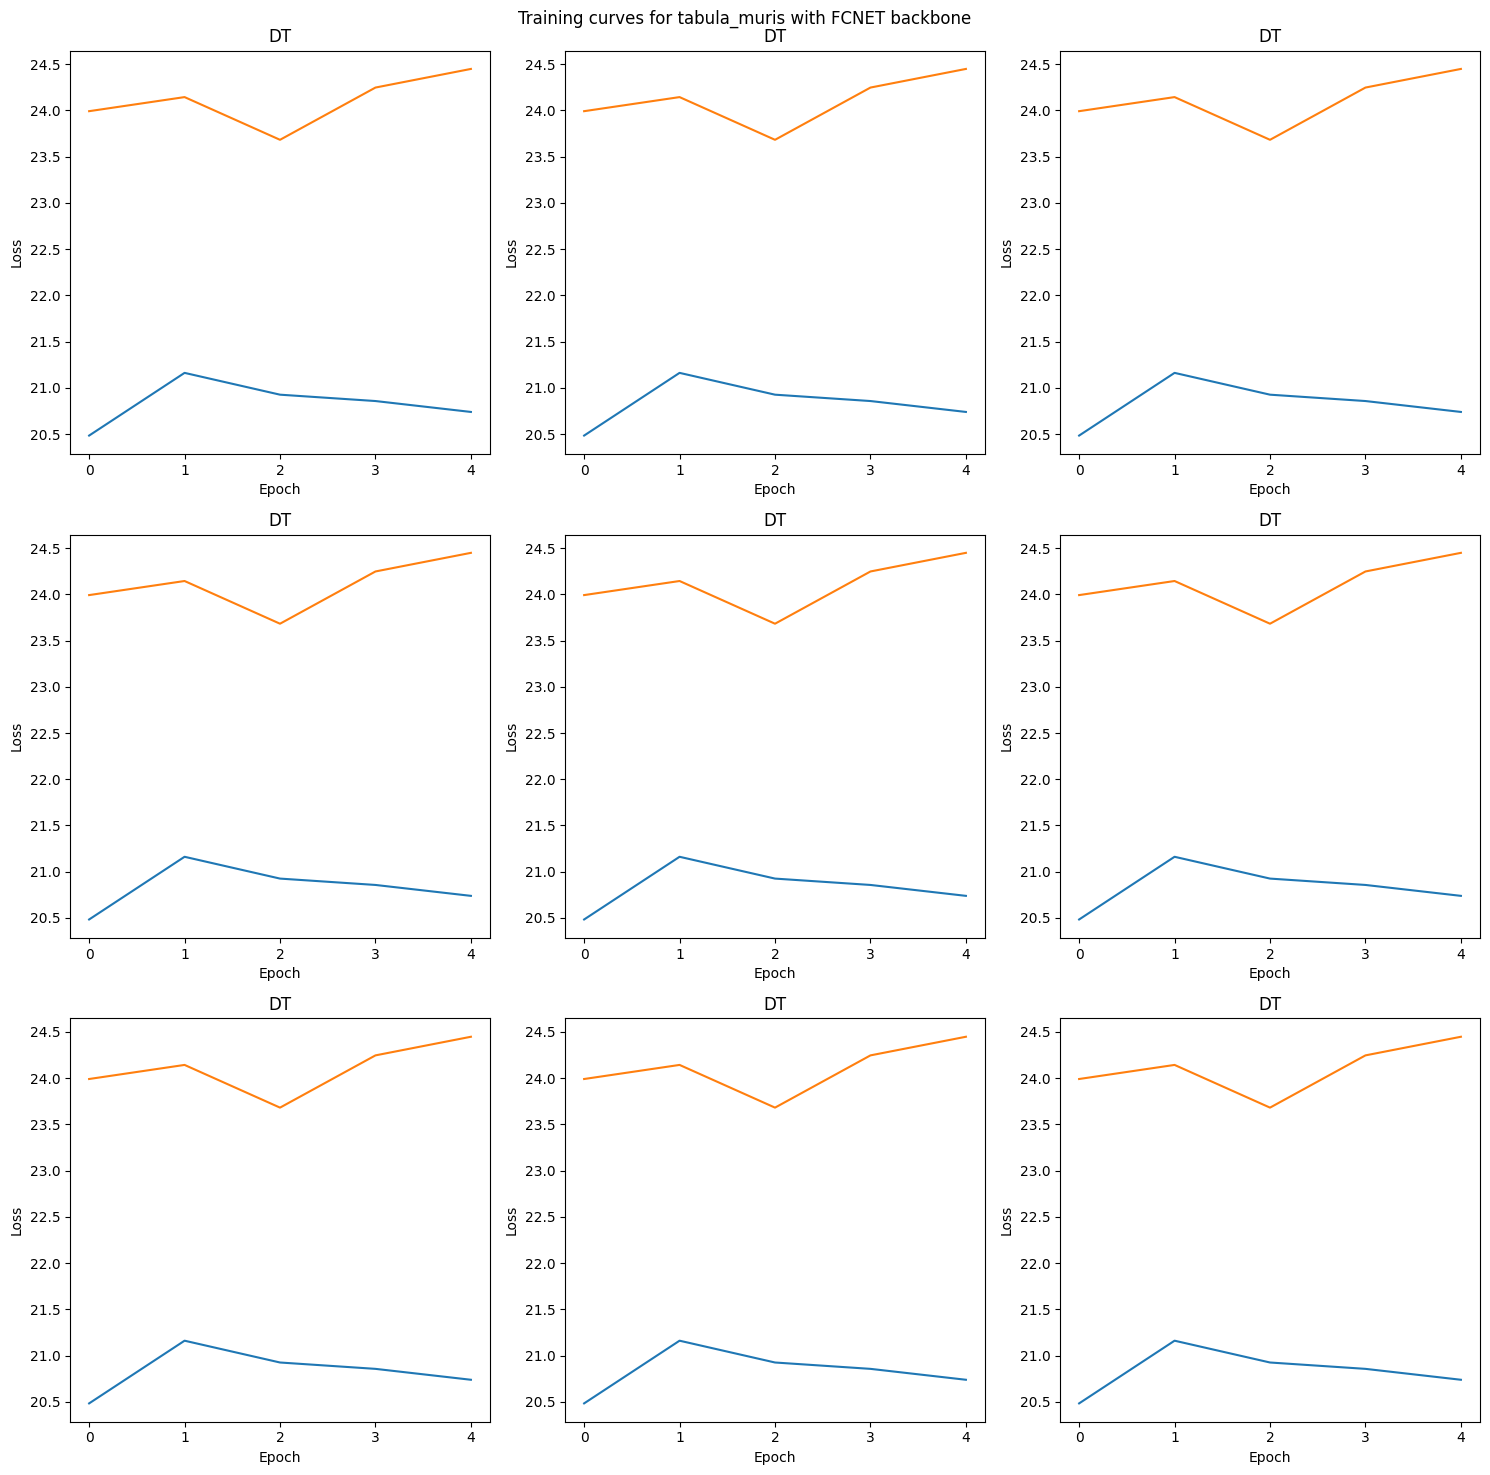

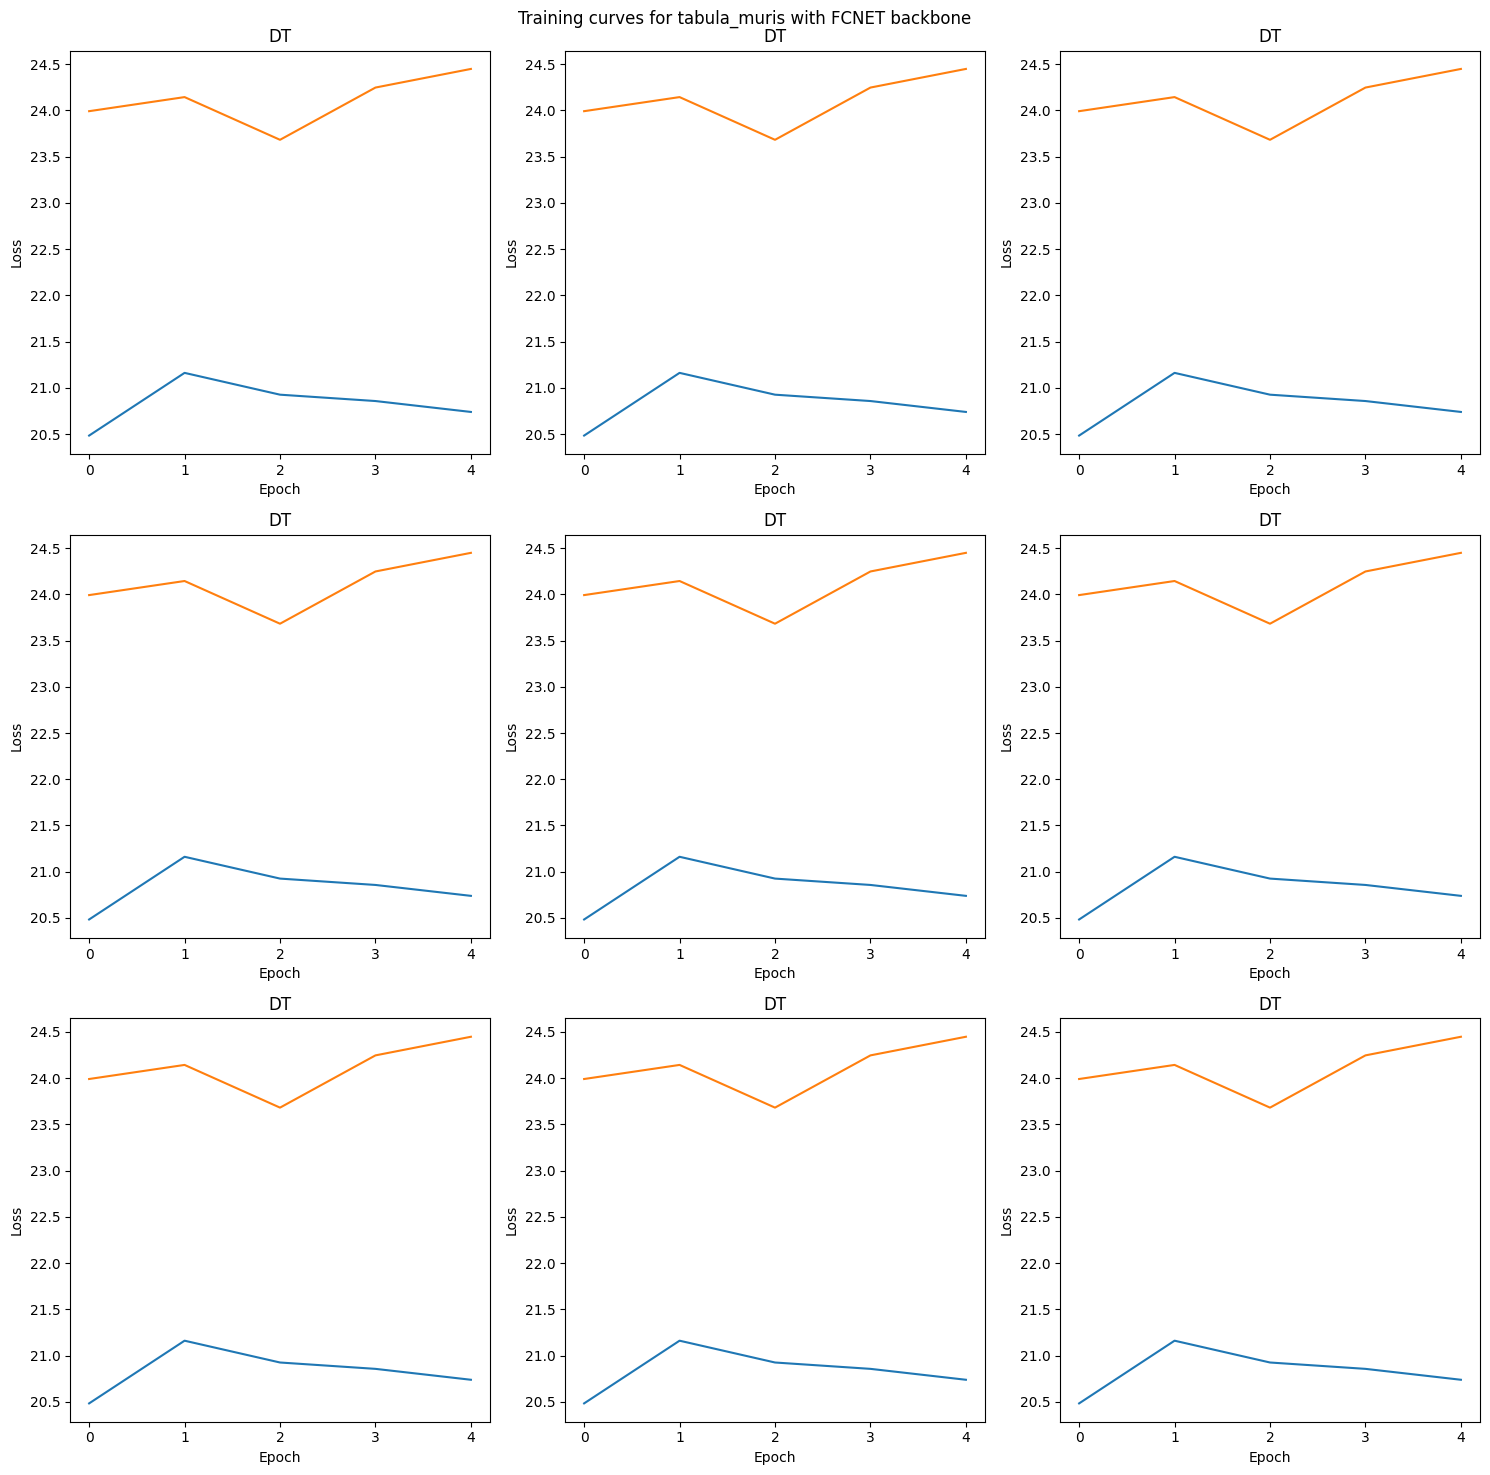

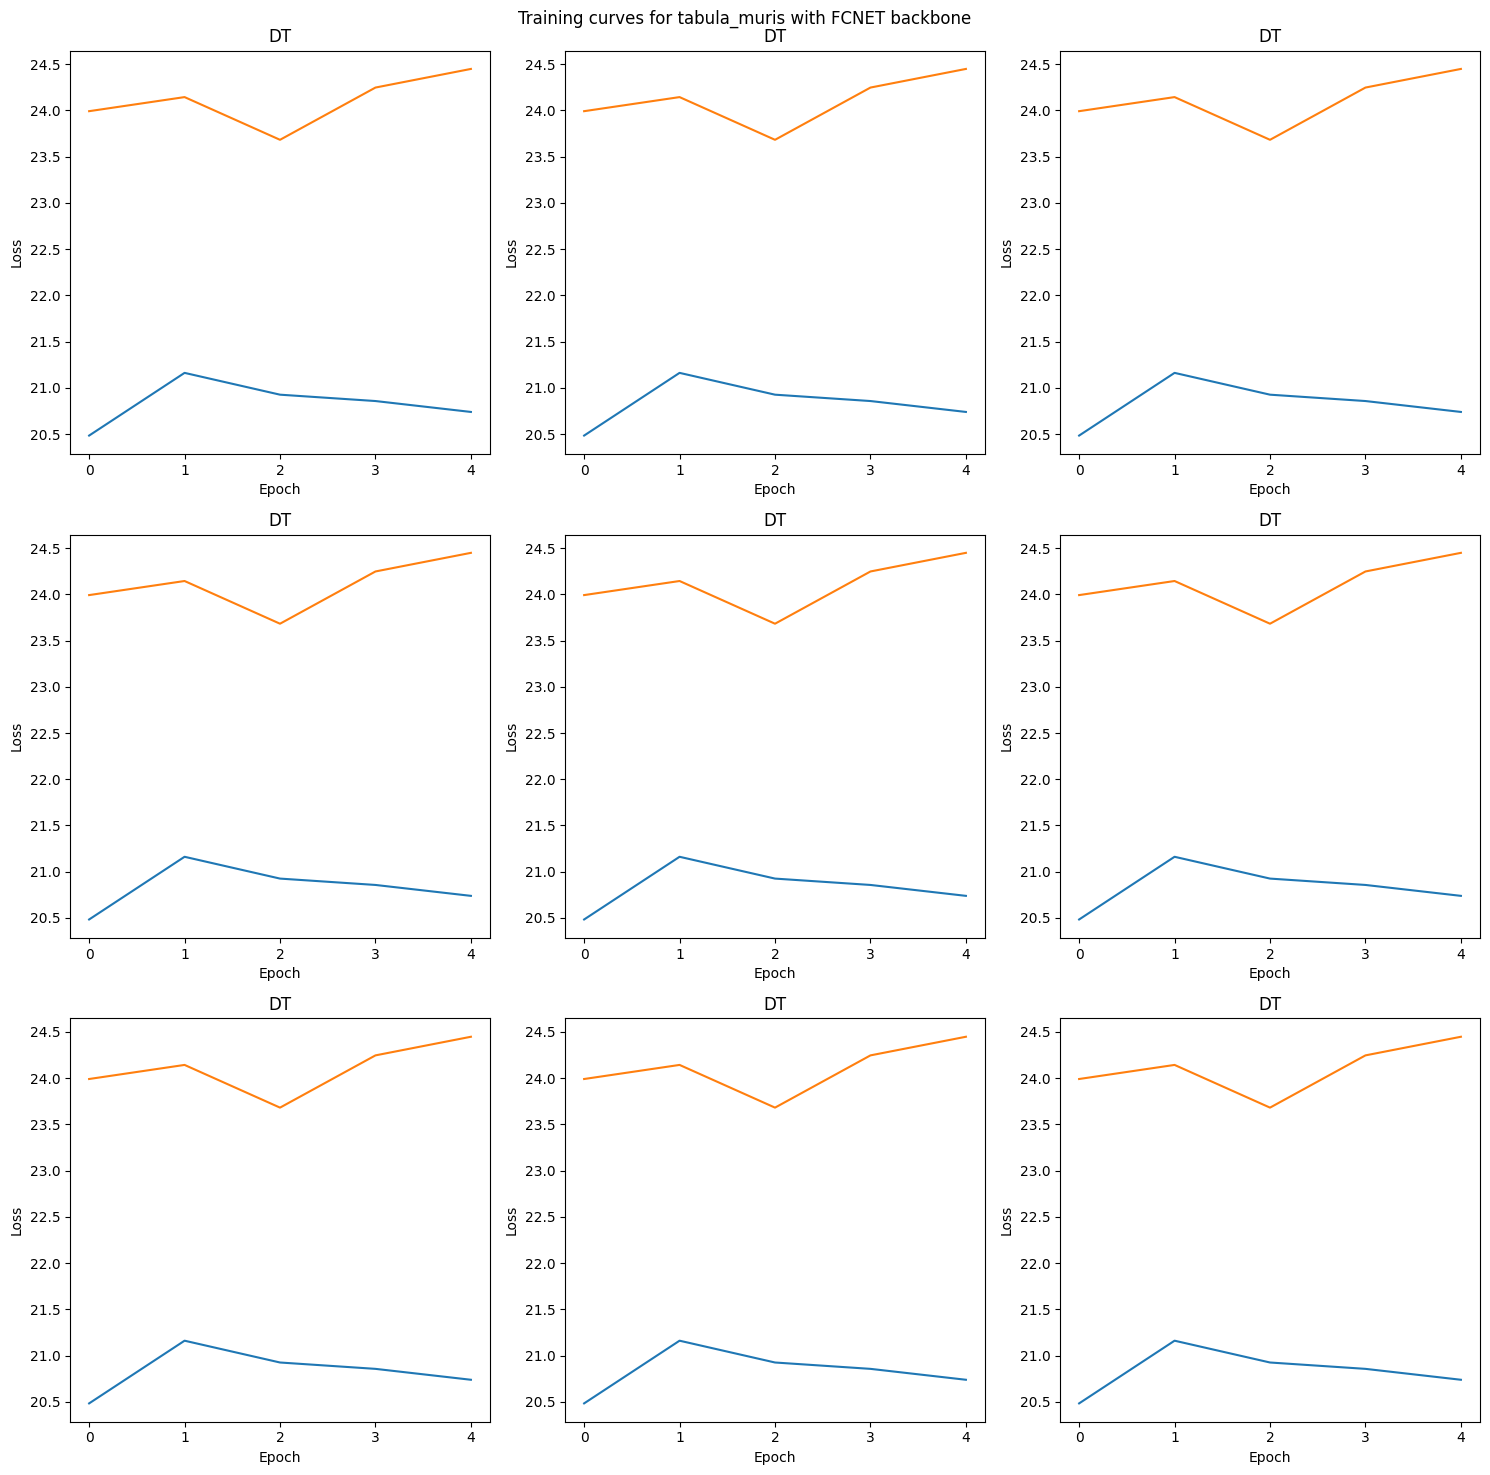

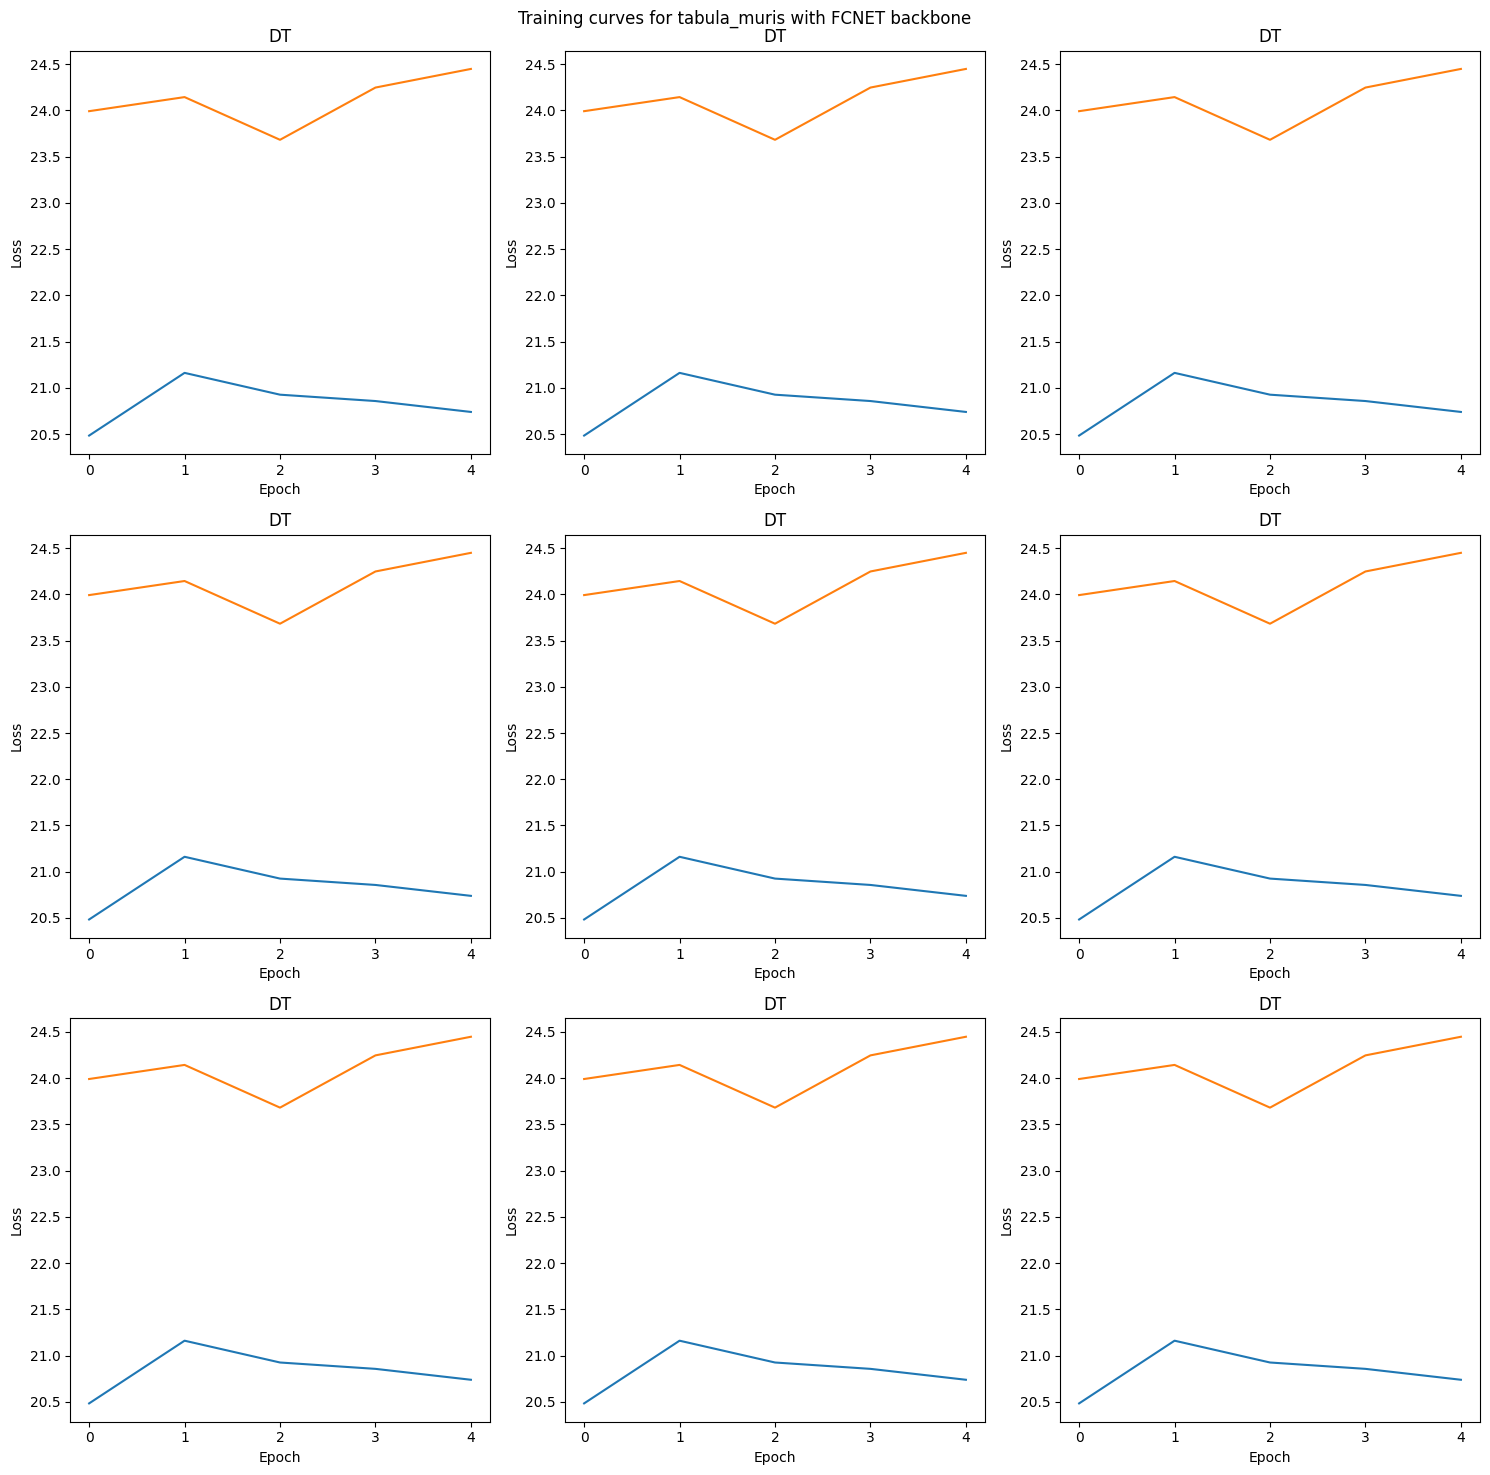

In [18]:
# Compare the training curve of the models
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
classifiers = ["DT", "DT", "DT", "DT", "DT", "DT", "DT", "DT", "DT"]
datasets = ["tabula_muris", "tabula_muris"]

total_classifiers = len(classifiers)

for backbone in backbones:
    for dataset in datasets:
        fig, ax = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"Training curves for {dataset} with {backbone} backbone")
        
        for index, classifier in enumerate(classifiers):
            
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "epoch_train_results.csv")

            epochs = data["epoch"].astype(str)
            val_loss = data["val_loss"]
            train_loss = data["train_loss"]
            
            ax[index//3, index%3].plot(epochs, val_loss, label="Validation loss")
            ax[index//3, index%3].plot(epochs, train_loss, label="Training loss")
            ax[index//3, index%3].set_title(f"{classifier}")
            ax[index//3, index%3].set_xlabel("Epoch")
            ax[index//3, index%3].set_ylabel("Loss")

        fig.tight_layout()
        plt.show()



### Plotting the model accuracy

Here, we plot the performance of each classifier for the training data.

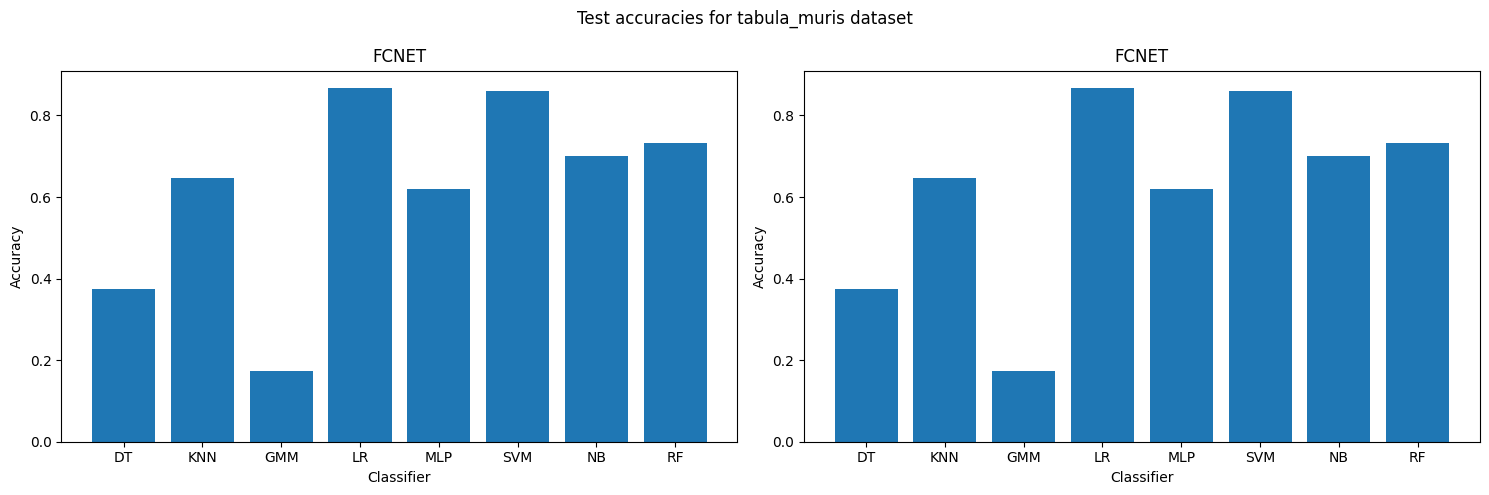

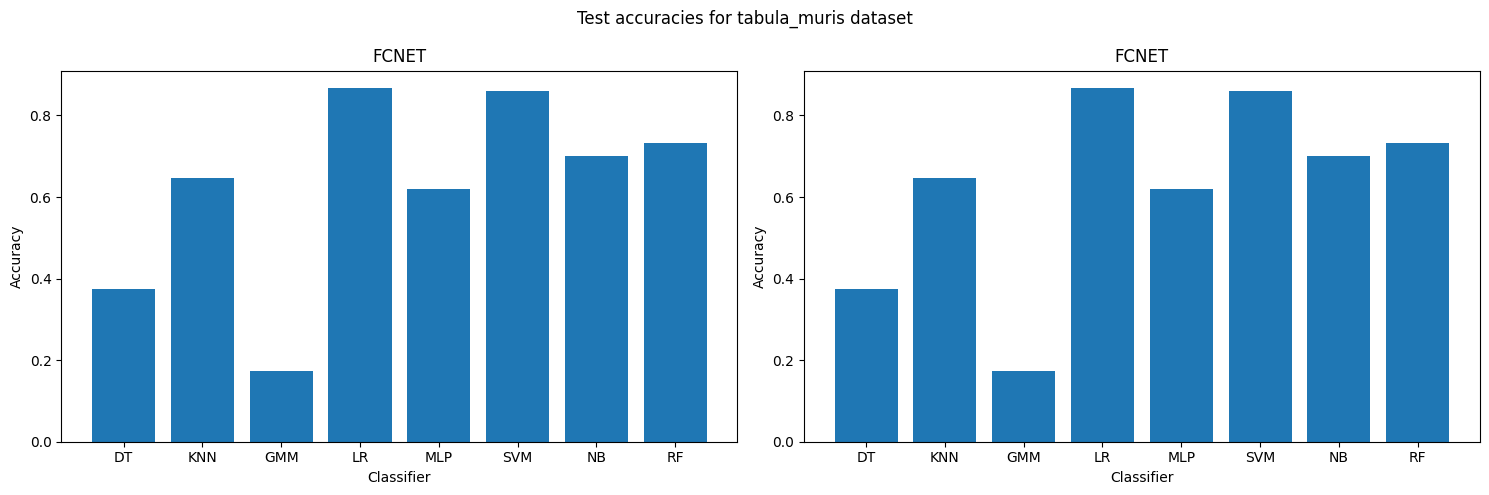

In [63]:
# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
classifiers = ["DT", "KNN","GMM", "LR", "MLP", "SVM", "NB", "RF"]
datasets = ["tabula_muris", "tabula_muris"]

total_classifiers = len(classifiers)
    
for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Test accuracies for {dataset} dataset")
    for index, backbone in enumerate(backbones):
        classifier_accuracies = []
        for _, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "test_summary.csv")

            test_line = data.iloc[2]
            classifier_accuracies.append(test_line["head_query_acc_mean"])
            
        ax[index].bar(classifiers, classifier_accuracies)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Classifier")
        ax[index].set_ylabel("Accuracy")
    
    fig.tight_layout()
    plt.show()

### Fitting time comparison

Which models needs the least fitting time?

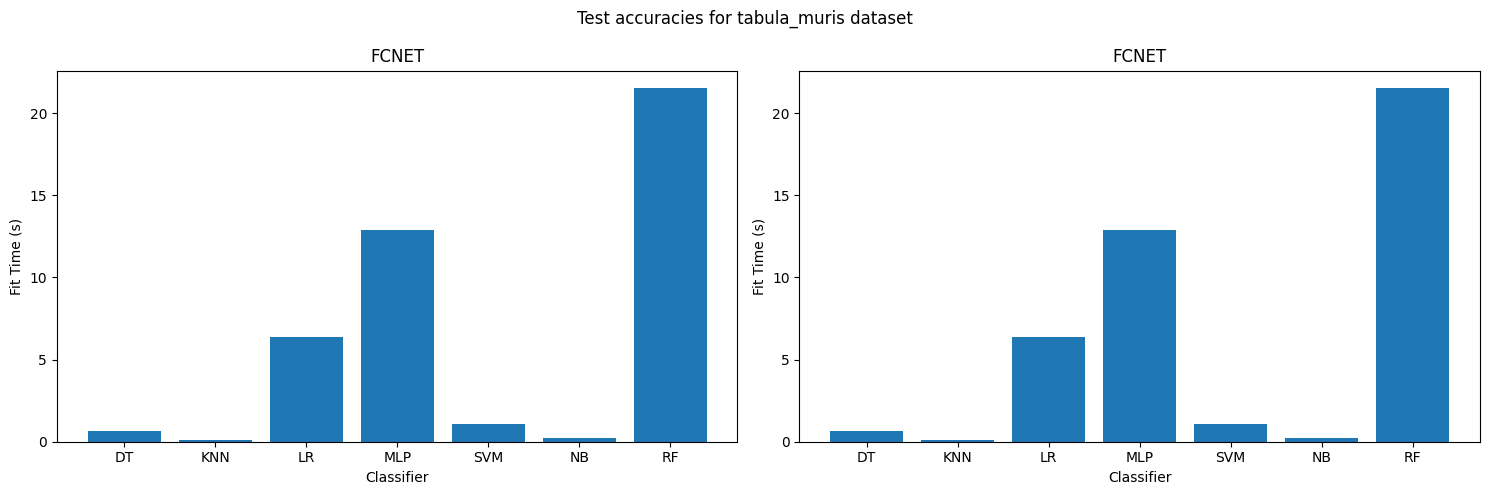

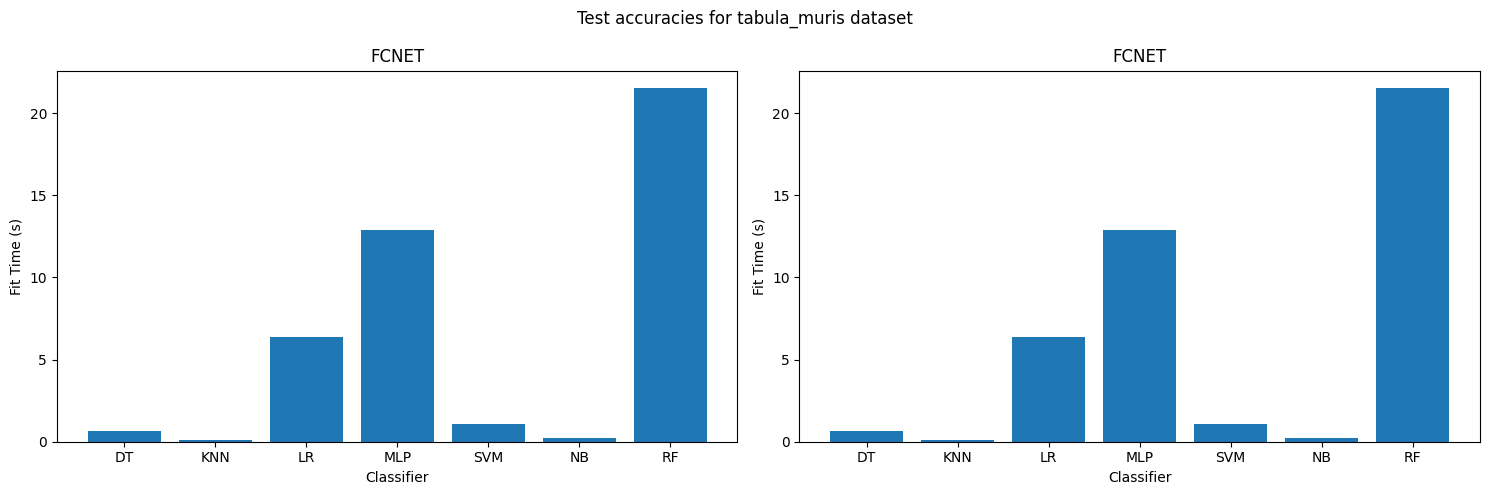

In [65]:
# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
classifiers = ["DT", "KNN", "LR", "MLP", "SVM", "NB", "RF"]
datasets = ["tabula_muris", "tabula_muris"]

total_classifiers = len(classifiers)
    
for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Test accuracies for {dataset} dataset")
    for index, backbone in enumerate(backbones):
        classifier_times = []
        for _, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")

            test_line = data.iloc[0]
            classifier_times.append(test_line["total_head_fit_time"])
            
        ax[index].bar(classifiers, classifier_times)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Classifier")
        ax[index].set_ylabel("Fit Time (s)")
    
    fig.tight_layout()
    plt.show()

### Fitting time in comparison with total training time

Is it really significant?

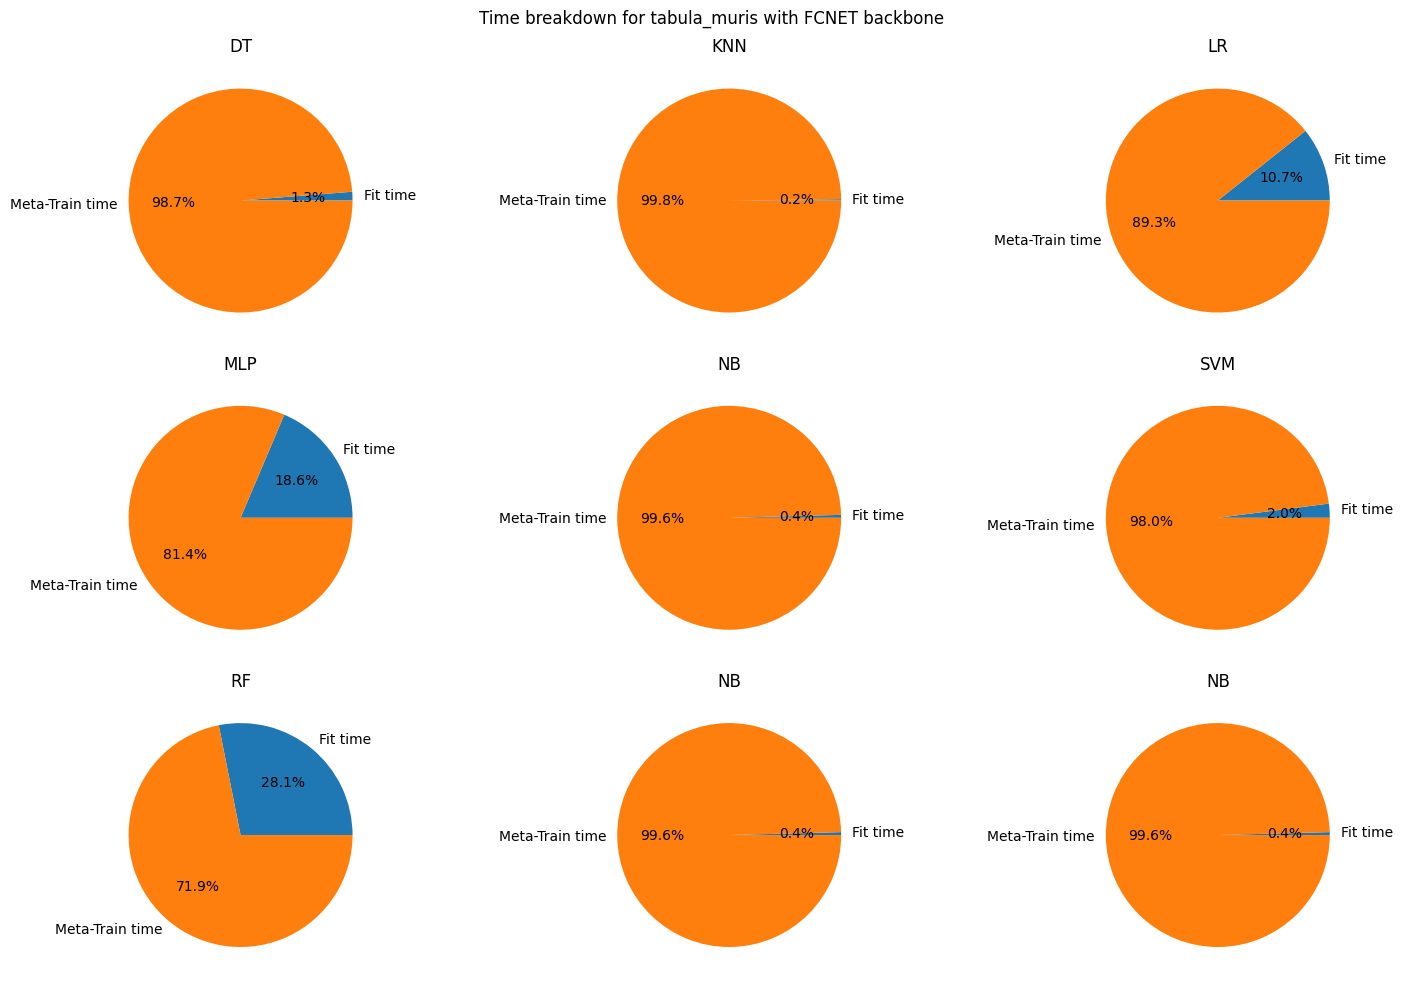

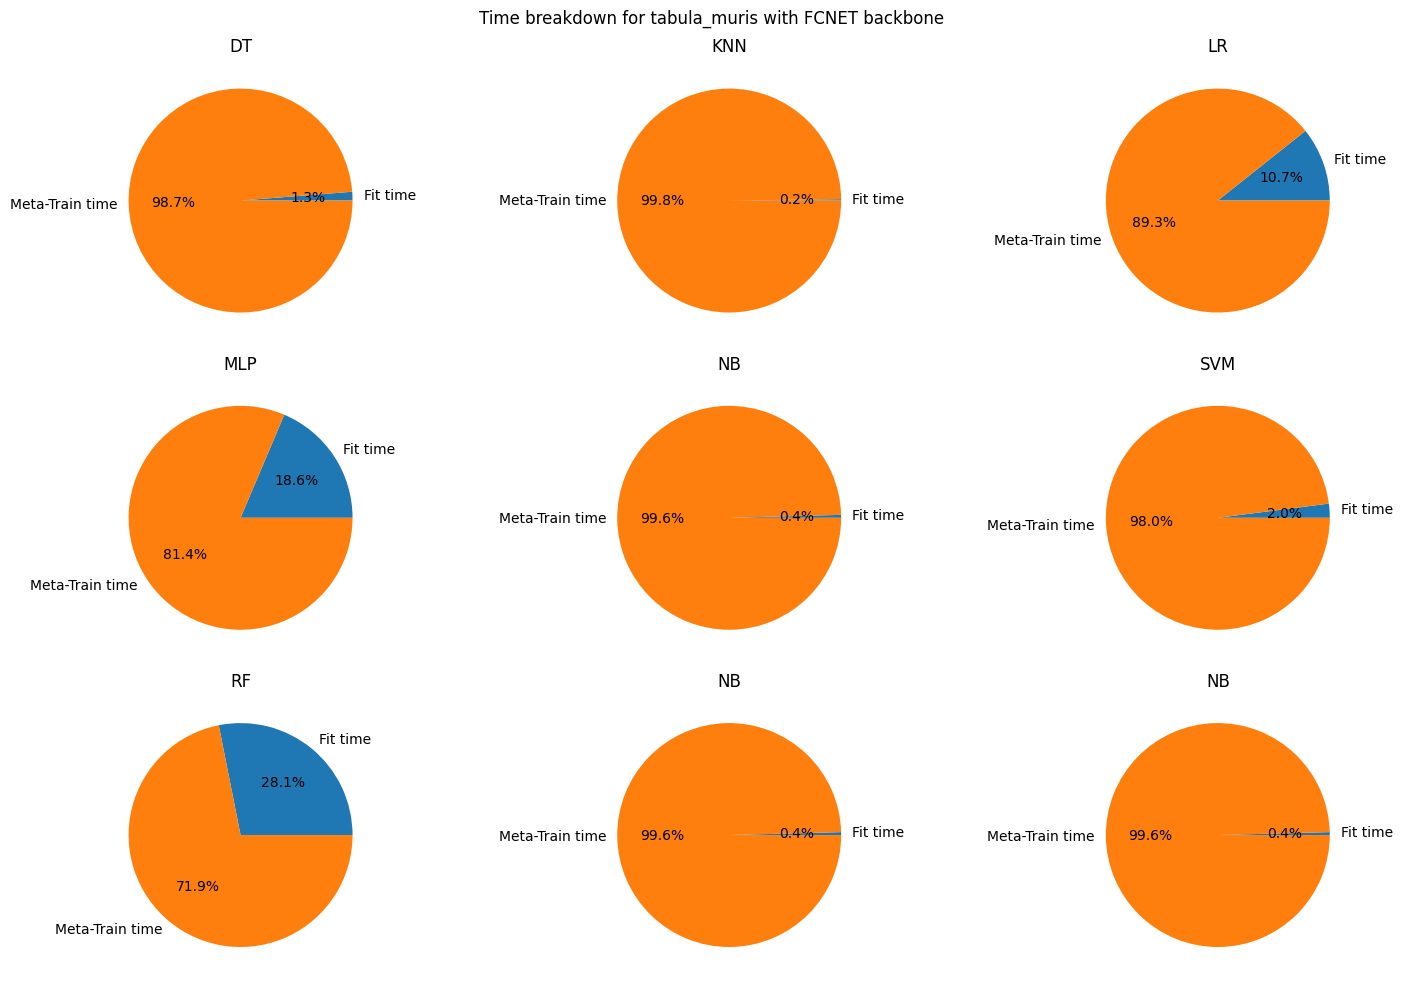

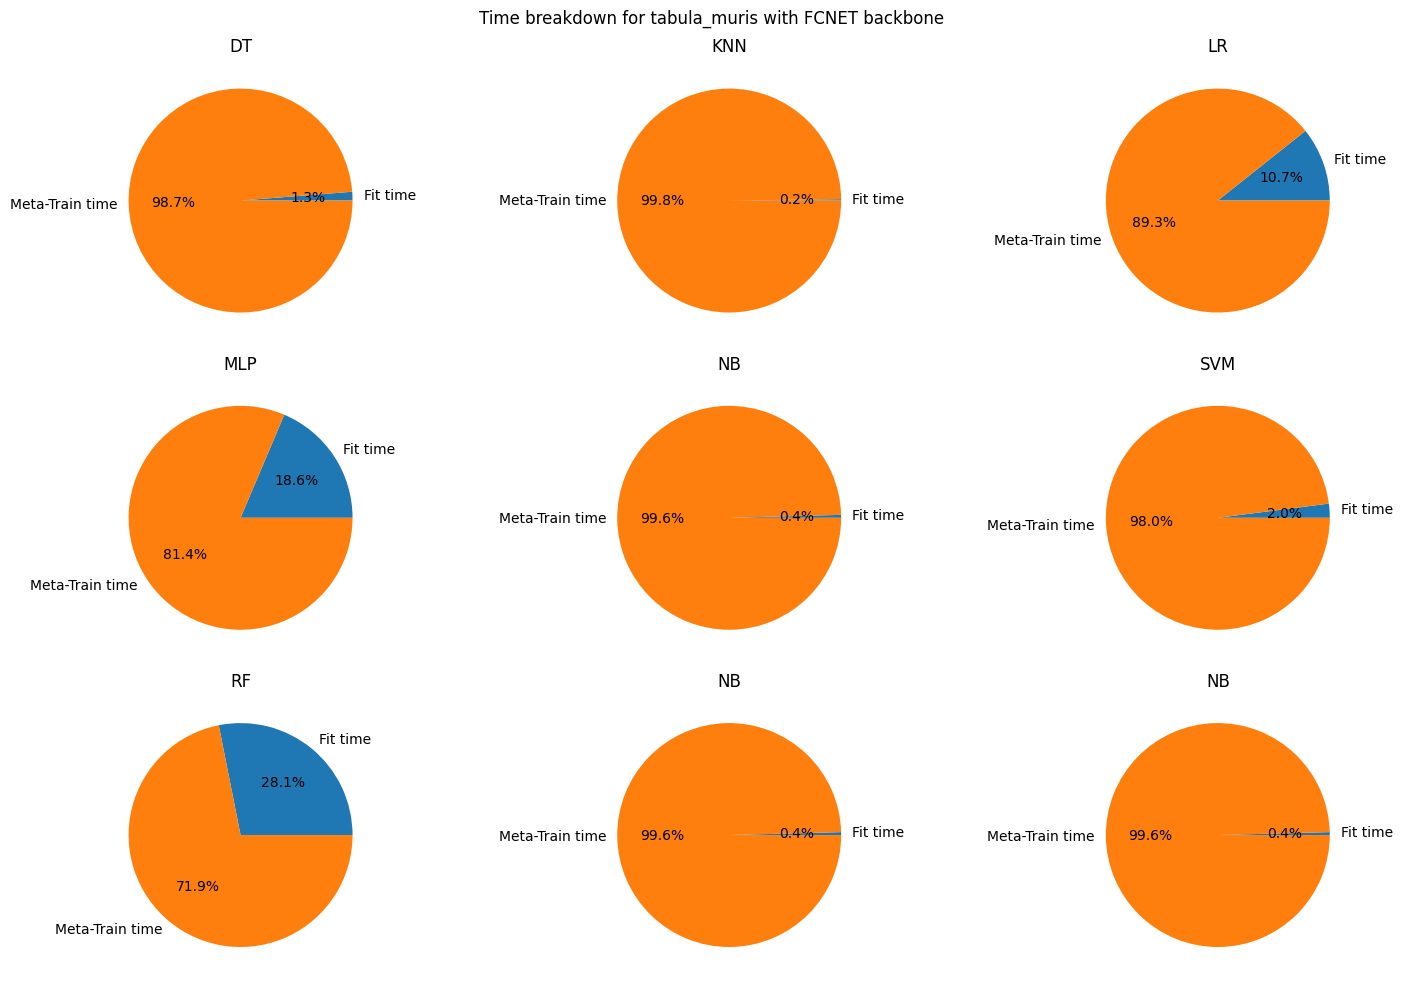

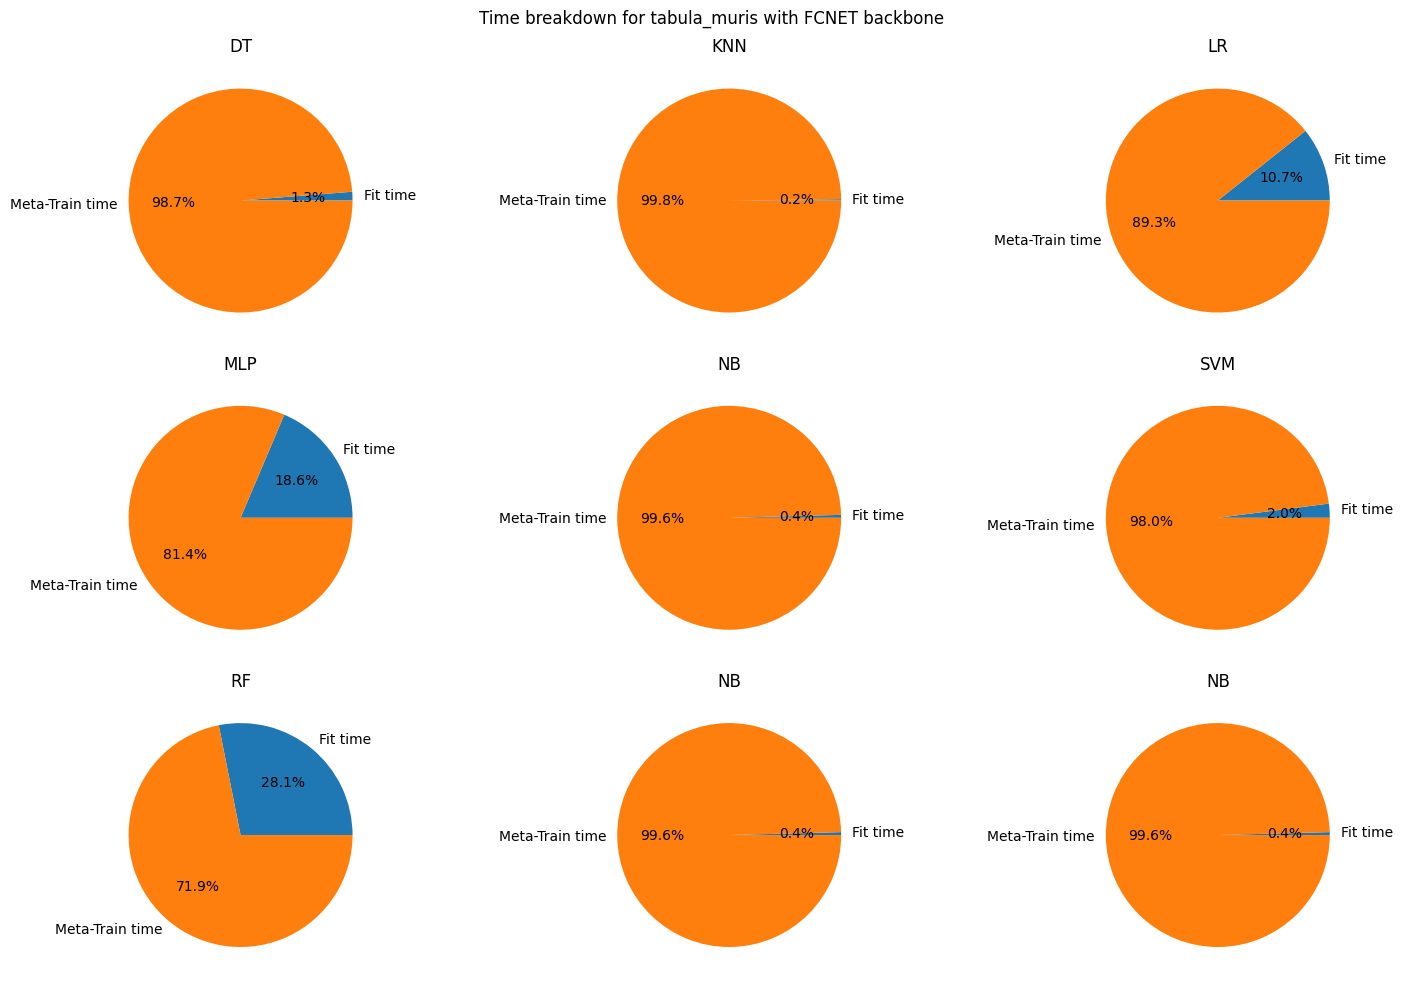

In [45]:
# Compare the overall test accuracies for BioMON

# Compare the classifier test accuracies
n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
classifiers = ["DT", "KNN", "LR", "MLP", "NB", "SVM", "RF", "NB", "NB"]
datasets = ["tabula_muris", "tabula_muris"]

total_classifiers = len(classifiers)

for backbone in backbones:
    for _, dataset in enumerate(datasets):
        fig, ax = plt.subplots(3, 3, figsize=(15, 10))
        for index, classifier in enumerate(classifiers):
            path = f"{RESULTS_DIR}/{dataset}/bioMON_{classifier}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")

            test_line = data.iloc[0]
            #classifier_accuracies.append(test_line["total_head_fit_time"])
            fit_time = test_line["total_head_fit_time"]
            total_time = test_line["total_training_time"]
            train_time = total_time - fit_time
            
            ax[index//3, index%3].pie([fit_time, train_time], labels=["Fit time", "Meta-Train time"], autopct='%1.1f%%')
            ax[index//3, index%3].set_title(f"{classifier}")
        
        fig.suptitle(f"Time breakdown for {dataset} with {backbone} backbone")
        fig.tight_layout()
        plt.show()
            
        

    

## Comparison with other few-shot learning algorithms

In this section, we will compare the results of our best-performing bioMON variation with other algorithms. 


## Comparison of the final test accuracy

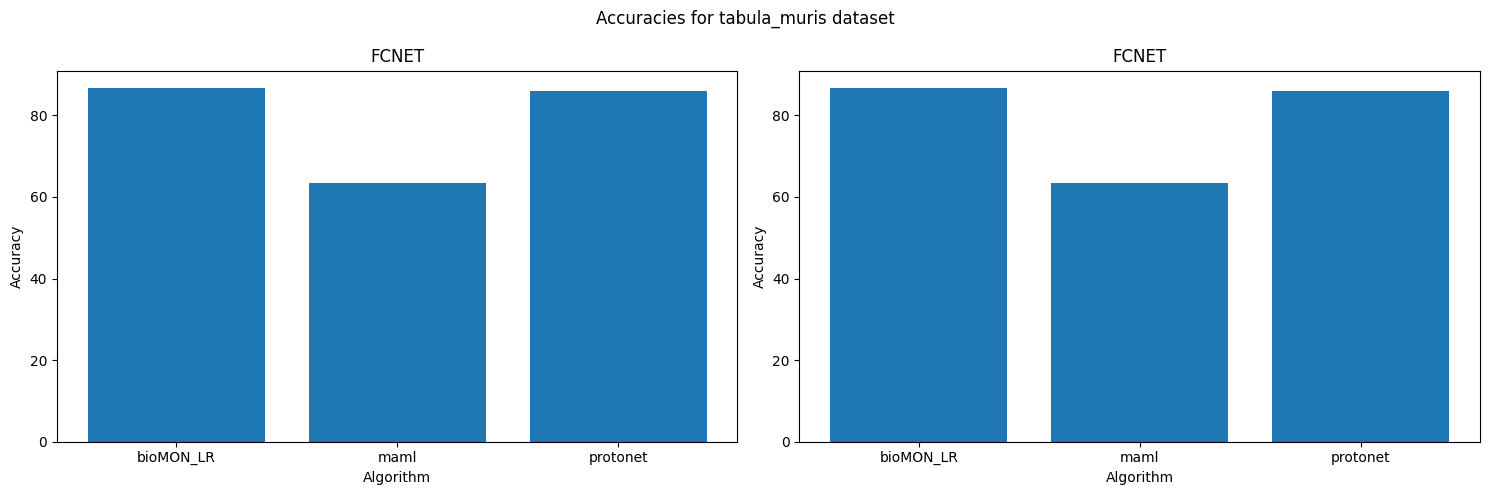

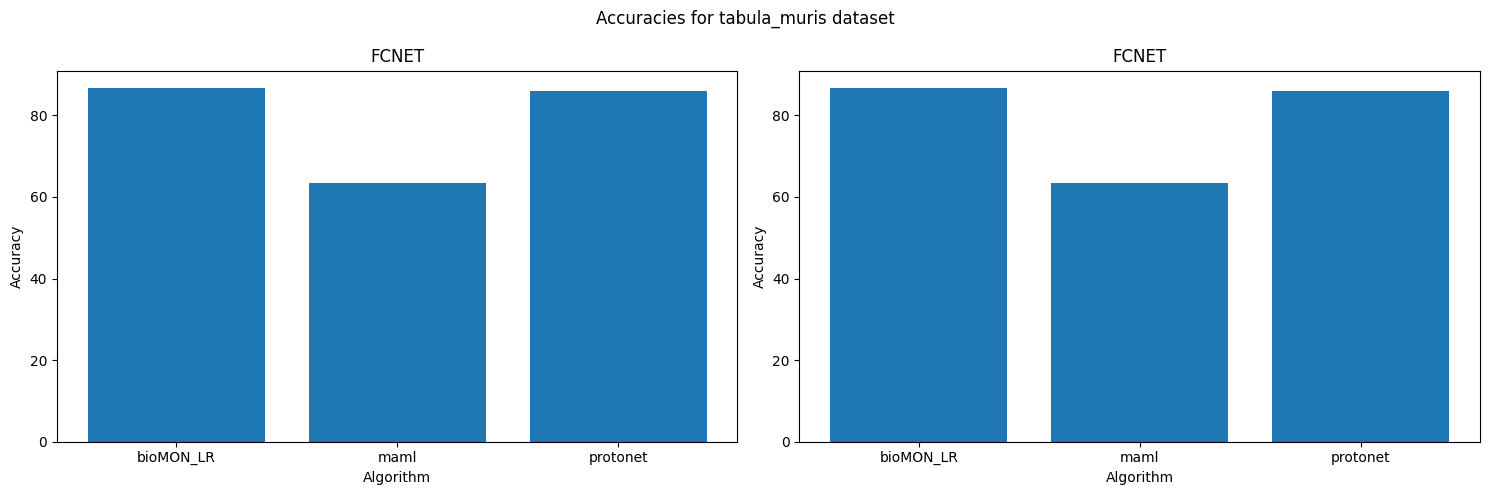

In [66]:
algos = ["bioMON_LR", "maml", "protonet"]

n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
datasets = ["tabula_muris", "tabula_muris"]
    
for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Accuracies for {dataset} dataset")
    
    for index, backbone in enumerate(backbones):    
        algo_accuracies = []
        for _, algo in enumerate(algos):
            path = f"{RESULTS_DIR}/{dataset}/{algo}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "test_summary.csv")

            test_line = data.iloc[2]
            algo_accuracies.append(test_line["acc_mean"])

        ax[index].bar(algos, algo_accuracies)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Algorithm")
        ax[index].set_ylabel("Accuracy")

    fig.tight_layout()
    plt.show()


### Comparison of the total training times of each model

FileNotFoundError: [Errno 2] No such file or directory: './results/final/FCNET/bioMON_LR_FCNET/5w5s15q/train_summary.csv'

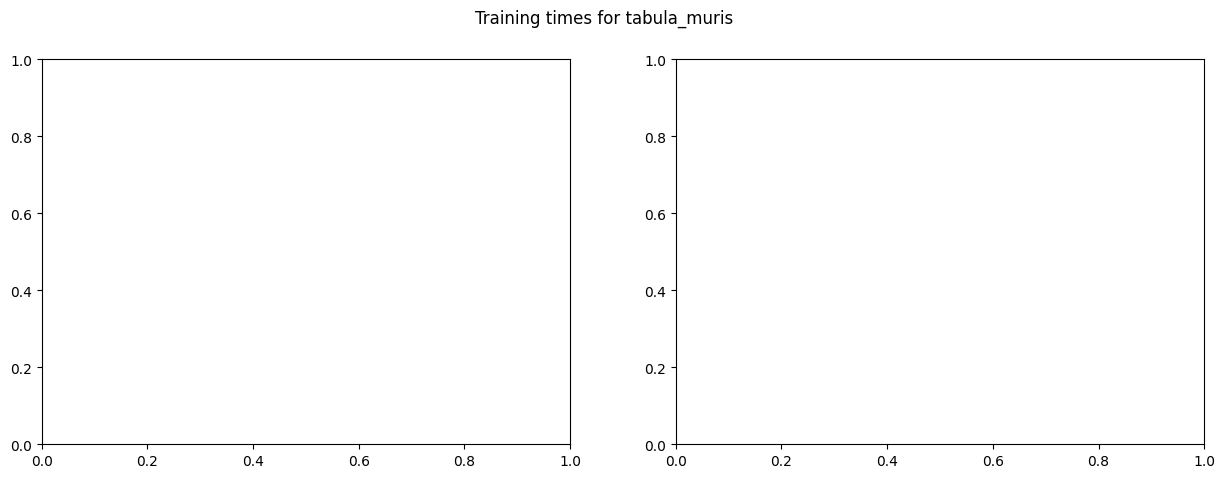

In [67]:
algos = ["bioMON_LR", "maml", "protonet"]

n_way = 5
n_shot = 5
n_query = 15

backbones = ["FCNET", "FCNET"]
datasets = ["tabula_muris", "tabula_muris"]

for dataset in datasets:
    fig, ax = plt.subplots(1, len(backbones), figsize=(15, 5))
    fig.suptitle(f"Training times for {dataset}")
    
    for index, backbone in enumerate(backbones):    
        algo_accuracies = []
        for _, algo in enumerate(algos):
            path = f"{RESULTS_DIR}/{dataset}/{algo}_{backbone}/{n_way}w{n_shot}s{n_query}q/"
            data = pd.read_csv(path + "train_summary.csv")

            test_line = data.iloc[0]
            algo_accuracies.append(test_line["total_training_time"])

        ax[index].bar(algos, algo_accuracies)
        ax[index].set_title(f"{backbone}")
        ax[index].set_xlabel("Algorithm")
        ax[index].set_ylabel("Training Time (s)")

    fig.tight_layout()
    plt.show()